In [1]:
import pandas as pd
import numpy as np
import requests
import os
import pickle
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
print('Completed imports...')

plt.rcParams['font.size'] = 8
plt.rcParams['legend.loc'] = 'right'
plt.rcParams['figure.titlesize'] = 'x-small'

prefix = 'https://stats.oecd.org/sdmx-json/data/DP_LIVE'
suffix = (
    '.../OECD?contentType=csv&detail=code'
    '&separator=comma&csv-lang=en'
)
urls = [prefix + x + suffix for x in ['/.GDP', '/.HUR', '/.CPI']]
names = ['gdp', 'unemployment', 'cpi']

def read_func(url):
    try:
        return pd.read_csv(url)
    except Exception:
        print(f'Failed at {url}')

if not all(os.path.isfile(f'./data/{x}.pickle') for x in names):
    dfs = {
        name: read_func(url)
        for name, url in zip(names, urls)
    }
    for name, df in dfs.items():
        with open(f'./data/{name}.pickle', 'wb') as fh:
            pickle.dump(df, fh)
    print('Completed file reading...')
else:
    dfs = {}
    for name in names:
        with open(f'./data/{name}.pickle', 'rb') as fh:
            dfs[name] = pickle.load(fh)
    print('Completed unpickling...')

def get_ticks(yrs2):
    major, minor = [], []
    for ix, x in enumerate(yrs2):
        ar =  major if x[-1] in list('05') else minor
        ar.append(ix)
    return major, minor

def axes_new_pos(ax):
    pos = ax.get_position()
    width, height = 0.8 * (pos.x1 - pos.x0), pos.y1 - pos.y0
    return [pos.x0, pos.y0, width, height]

def make_intl_title(st):
    return f'{st}:\nU.S., Great Britain,\nGermany, and France'

Completed imports...
Completed unpickling...


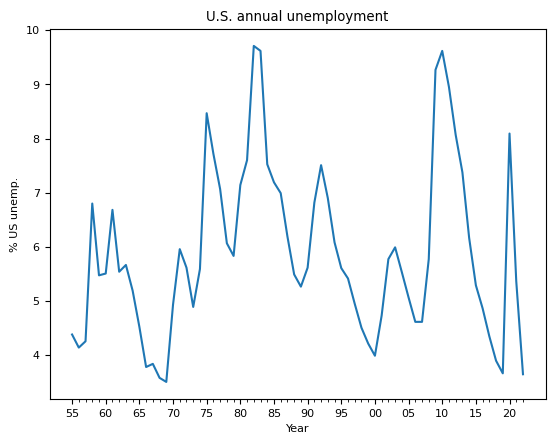

In [2]:
un_df = dfs['unemployment']
countries = ["USA", "FRA", "DEU", "GBR"]
qstring = '(FREQUENCY == "A") & (LOCATION == "USA") & (SUBJECT == "TOT")'
    
fig, us_unemp_ax = plt.subplots()
df = un_df.reset_index(drop=True).query(qstring).loc[:, ['TIME', 'Value']]
df = df.sort_values('TIME')
df['TIME'] = pd.to_numeric(df['TIME']).apply(lambda x: f'{x % 100:02d}')
major, minor = get_ticks(df['TIME'].values)
us_unemp_ax.set_xticks(major)
us_unemp_ax.set_xticks(minor, minor=True)
us_unemp_ax.set(xlabel='Year', ylabel='% US unemp.')
us_unemp_ax.set_title('U.S. annual unemployment')
sns.lineplot(data=df, x='TIME', y='Value', ax=us_unemp_ax);


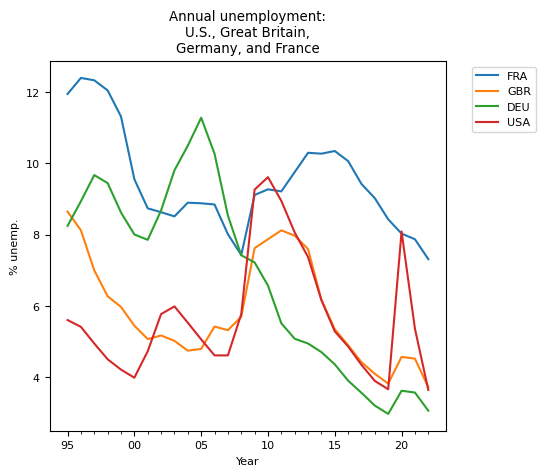

In [3]:
fig, int_unemp_ax = plt.subplots()
qstring2 = (
    '(FREQUENCY == "A") & (LOCATION in @countries) & (SUBJECT == "TOT")'
)
fs = ['FREQUENCY', 'SUBJECT']
cols = ['TIME', 'LOCATION', 'Value']
int_df = un_df.query(qstring2).loc[:, cols]
int_df = int_df.query('"1995" <= TIME <= "2022"').sort_values(by=['TIME'])


int_df['TIME'] = (
    pd.to_numeric(int_df['TIME']).apply(lambda x: f'{x % 100:02d}')
)
int_df = int_df.rename({'LOCATION': 'Country'}, axis=1)
sns.lineplot(
    data=int_df, x='TIME', y='Value', hue='Country', ax=int_unemp_ax
)
tickvals = int_df['TIME'].drop_duplicates().values
major, minor = get_ticks(tickvals)
ticklabels = [tickvals[x][-2:] for x in major]

int_unemp_ax.set_xticks(major, labels=ticklabels)
int_unemp_ax.set_xticks(minor, minor=True)
int_unemp_ax.set(
    xlabel='Year', ylabel='% unemp.',
    position=axes_new_pos(int_unemp_ax),
    title=make_intl_title('Annual unemployment')
)
int_unemp_ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1.0));

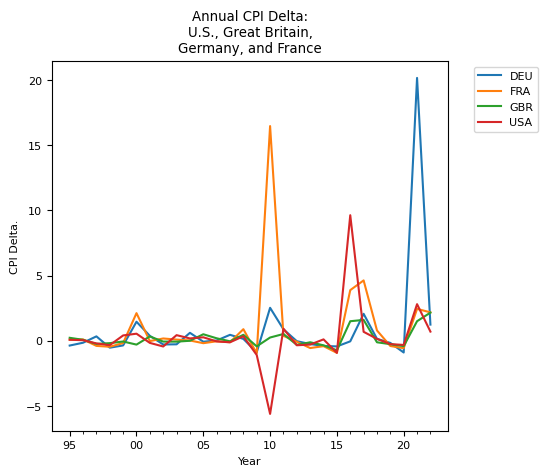

In [4]:
fig, cpi_ax = plt.subplots()
qstring3 = f'{qstring2} & (MEASURE == "AGRWTH")'
cpi_df = (
    dfs['cpi'].query(qstring3).loc[:, cols].set_index(['TIME', 'LOCATION'])
    .groupby(level='LOCATION').pct_change().unstack('LOCATION')
)
cpi_df.columns = cpi_df.columns.droplevel().rename(None)
cpi_df = cpi_df.loc['1995':'2022', :].reset_index()
cpi_df['TIME'] = (
    pd.to_numeric(cpi_df['TIME']).apply(lambda x: f'{x % 100:02d}')
)
melted_cpi_df = pd.melt(cpi_df, id_vars=['TIME'], var_name='Country')
sns.lineplot(
    x='TIME', y='value', hue='Country',
    data=melted_cpi_df, ax=cpi_ax
)
tickvals = melted_cpi_df['TIME'].drop_duplicates().values
major, minor = get_ticks(tickvals)
ticklabels = [tickvals[x][-2:] for x in major]
cpi_ax.set_xticks(major, labels=ticklabels)
cpi_ax.xaxis.set_ticks(minor, minor=True)
cpi_ax.set(
    xlabel='Year', ylabel='CPI Delta.', position=axes_new_pos(cpi_ax),
    title=make_intl_title('Annual CPI Delta')
)
cpi_ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1.0));

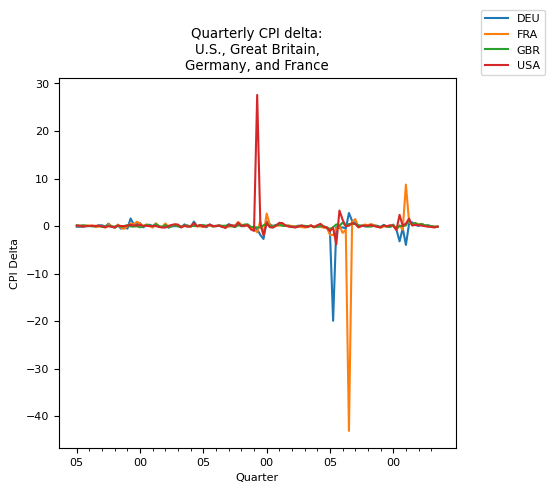

In [6]:
qstring4 = (
    '(FREQUENCY == "Q") & (LOCATION in @countries)'
    ' & (SUBJECT == "TOT") & (MEASURE == "AGRWTH")'
)
cpiq_df = (
    dfs['cpi'].query(qstring4).loc[:, cols].set_index(['TIME', 'LOCATION'])
    .groupby(level='LOCATION').pct_change().unstack('LOCATION')
)
cpiq_df.columns = cpiq_df.columns.droplevel().rename(None)
cpiq_df = cpiq_df.loc['1995-Q1':'2023-Q3', :].reset_index()

def conv(x):
    yr, qtr = (int(piece) for piece in x.split('-Q'))
    return yr + (qtr - 1)/4

cpiq_df['TIME'] = cpiq_df['TIME'].apply(conv)
melted_cpiq_df = pd.melt(
    cpiq_df, id_vars=['TIME'], var_name='Country'
)
fig, cpiq_ax = plt.subplots()
sns.lineplot(
    x='TIME', y='value', hue='Country',
    data=melted_cpiq_df, ax=cpiq_ax
)
tickvals = [
    x for x in cpiq_df['TIME'].values
    if x - int(x) < 0.1 and int(x) % 10 in [0, 5]
]
minortickvals = [
    x for x in cpiq_df['TIME'].values
    if x - int(x) < 0.1 and int(x) % 10 not in [0, 5]
]
ticklabels = [f'{int(x) % 10:02d}' for x in tickvals]
cpiq_ax.set_xticks(tickvals, labels=ticklabels)
cpiq_ax.set_xticks(minortickvals, minor=True)
cpiq_ax.set(
    xlabel='Quarter', ylabel='CPI Delta',
    position=axes_new_pos(cpiq_ax),
    title=make_intl_title('Quarterly CPI delta')
)
cpiq_ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1.2));

                  GDP  Unemployment
Country                            
LUX        145.972085      4.600000
IRL        134.149333      4.500000
SGP        127.607313           NaN
NOR        121.262559      3.233333
CHE         90.685775      4.299916
DNK         77.914886      4.475000
USA         76.291025      3.650000
NLD         74.533564      3.541667
AUS         71.861529      3.704242
ISL         71.840981      3.850000
AUT         70.889719      4.758333
BEL         68.285853      5.575000
SWE         68.239373      7.483333
DEU         66.616323      3.066667
FIN         62.759621      6.766667
CAN         61.380598      5.300000
MLT         57.607690           NaN
FRA         57.179841      7.316667
EU27_2020   57.098020      6.158333
EA19        56.874647      6.716667
GBR         56.765960      3.725000
OECDE       56.237721           NaN
OECD        55.681367      5.004017
ITA         55.373479      8.075000
CYP         52.304066           NaN
ISR         52.169318      3

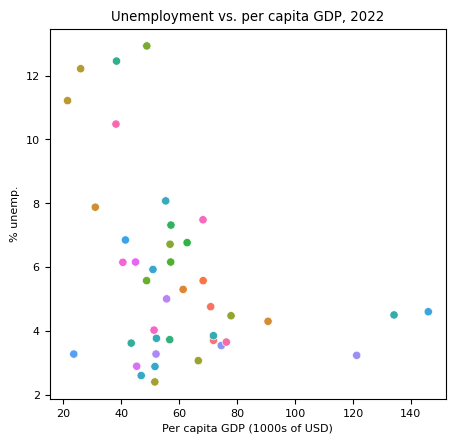

In [17]:
gdp22_df = (
    dfs['gdp']
    .query('(TIME == 2022) & (MEASURE == "USD_CAP")')
    .loc[:, ['LOCATION', 'Value']]
    .rename({'LOCATION': 'Country'}, axis=1)
    .set_index('Country', drop=True)
)
    
unemp22_df = (
    un_df.query('(TIME == "2022") & (SUBJECT == "TOT")')
    .loc[:, ['LOCATION', 'Value']]
    .rename({'LOCATION': 'Country'}, axis=1)
    .set_index('Country', drop=True)
)

gdp_unemp_22_df = pd.DataFrame.from_dict({
    'GDP': gdp22_df['Value'] / 1000,
    'Unemployment': unemp22_df['Value']
})

print(gdp_unemp_22_df.sort_values(by='GDP', ascending=False).to_string())
fig, gdp_unemp_22_ax = plt.subplots()
sns.scatterplot(
    data=gdp_unemp_22_df, x='GDP', y='Unemployment',
    ax=gdp_unemp_22_ax, hue='Country', legend=False
)
gdp_unemp_22_ax.set(
    title='Unemployment vs. per capita GDP, 2022',
    xlabel='Per capita GDP (1000s of USD)', ylabel='% unemp.',
    position=axes_new_pos(gdp_unemp_22_ax)
);